## Baseball Homerun Predictions for Y2021

We are going to attempt to accurately predict the amount of homeruns that will occur for the MLB 2021 Season. Since the season has already been completed and thus all the homeruns that can occur in the 2021 season have already happened, we have a fine measurement as to just how accurate our model will be. Our process will be fairly straightforward; we will do an ordinary least squares fit utilizing all of the predictors to get the p-values. After that, we will determine collinearity values using a VIF analysis. Then, we will perform subset selection using multiple techniques like forward subset selection. Finally, we will use that model to predict the amount of homeruns the next year and assess our accuracy. We are using data from the 2000-2020 seasons on players hitting stats organized by year. This dataset was obtained from SeanLahman.com and we used the Batting.csv dataset specifically. We had to clean up our dataset before we began since we only wanted yearly overall statistics and not individual player data. We combined all of the stats from every year and began our process. An initial disclaimer, the 2020 season was drastically shorter than every other season in the dataset due to the global pandemic and therefore the sample size is much smaller. However, we expect that the decrease in homeruns and games played will also be reflected in the other predictors proportionately so that it can still be reliably used as data.

In [1]:
# Basics and Plotting
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from itertools import chain, combinations

# Sklearn Models
import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# Alternative models
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

In [2]:
baseball = pd.read_csv("https://raw.githubusercontent.com/dswetlik/BaseballHRPrediction/master/Batting.csv")

In [3]:
baseball

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abbotje01,2000,1,CHA,AL,80,215,31,59,15,...,29,2,1,21,38,1,2,2,1,2
1,abbotku01,2000,1,NYN,NL,79,157,22,34,7,...,12,1,1,14,51,2,1,0,1,2
2,abbotpa01,2000,1,SEA,AL,35,5,1,2,1,...,0,0,0,0,1,0,0,1,0,0
3,abreubo01,2000,1,PHI,NL,154,576,103,182,42,...,79,28,8,100,116,9,1,0,3,12
4,aceveju01,2000,1,MIL,NL,62,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29518,zimmebr02,2020,1,BAL,AL,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29519,zimmejo02,2020,1,DET,AL,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29520,zimmeky01,2020,1,KCA,AL,16,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29521,zuberty01,2020,1,KCA,AL,23,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Below we are dropping the columns playerID, teamID, stint, and lgID, as we have decided that they would be inconsequential or irrelavent for determining league-wide homerun counts.

In [4]:
baseball.drop(columns=["playerID","teamID","stint","lgID"], axis=1, inplace=True)
baseball.rename(columns={"2B": "Double", "3B": "Triple"}, inplace=True)
baseball.head()

,yearID,G,AB,R,H,Double,Triple,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,2000,80,215,31,59,15,1,3,29,2,1,21,38,1,2,2,1,2
1,2000,79,157,22,34,7,1,6,12,1,1,14,51,2,1,0,1,2
2,2000,35,5,1,2,1,0,0,0,0,0,0,1,0,0,1,0,0
3,2000,154,576,103,182,42,10,25,79,28,8,100,116,9,1,0,3,12
4,2000,62,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0


This is almost usable for what we want, but it is still organized per-player, and we want it to be based on the year's total statistics. We will go through and create a new dataset now based on years.

In [14]:
baseballYearTotal = []
for i in range(2000,2021):
    baseballYear = baseball.loc[baseball['yearID'] == i].to_dict(orient='dict')
    G = 0
    for j in baseballYear['G'].values():
        G += j
    AB = 0
    for j in baseballYear['AB'].values():
        AB += j
    R = 0
    for j in baseballYear['R'].values():
        R += j
    H = 0
    for j in baseballYear['H'].values():
        H += j
    Double = 0
    for j in baseballYear['Double'].values():
        Double += j
    Triple = 0
    for j in baseballYear['Triple'].values():
        Triple += j
    HR = 0
    for j in baseballYear['HR'].values():
        HR += j
    RBI = 0
    for j in baseballYear['RBI'].values():
        RBI += j
    SB = 0
    for j in baseballYear['SB'].values():
        SB += j
    CS = 0
    for j in baseballYear['CS'].values():
        CS += j
    BB = 0
    for j in baseballYear['BB'].values():
        BB += j
    SO = 0
    for j in baseballYear['SO'].values():
        SO += j
    IBB = 0
    for j in baseballYear['IBB'].values():
        IBB += j
    HBP = 0
    for j in baseballYear['HBP'].values():
        HBP += j
    SH = 0
    for j in baseballYear['SH'].values():
        SH += j
    SF = 0
    for j in baseballYear['SF'].values():
        SF += j
    GIDP = 0
    for j in baseballYear['GIDP'].values():
        GIDP += j
    baseballYearTotal.append([i,G,AB,R,H,Double,Triple,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP])
    
newBaseball = pd.DataFrame(baseballYearTotal, columns=['yearID','G','AB','R','H','Double','Triple','HR','RBI','SB','CS','BB','SO','IBB','HBP','SH','SF','GIDP'])
newBaseball

,yearID,G,AB,R,H,Double,Triple,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,2000,68815,167290,24971,45246,8901,952,5693,23735,2924,1323,18237,31356,1210,1573,1628,1514,3892
1,2001,68511,166234,23199,43879,8813,928,5458,22088,3103,1408,15806,32404,1384,1890,1607,1424,3653
2,2002,68345,165582,22408,43272,8700,921,5059,21332,2750,1282,16246,31394,1452,1746,1633,1399,3845
3,2003,68534,166737,22978,44057,8827,934,5207,21886,2573,1132,15889,30801,1316,1849,1626,1336,3850
4,2004,68882,167353,23376,44522,8919,898,5451,22248,2589,1100,16222,31828,1381,1850,1731,1363,3784
5,2005,68435,166335,22325,43991,8863,888,5017,21248,2565,1069,15207,30644,1216,1797,1620,1315,3908
6,2006,69332,167341,23599,45073,9135,952,5386,22491,2767,1110,15847,31655,1410,1817,1651,1396,3945
7,2007,70143,167783,23322,44977,9197,938,4957,22257,2918,1002,16079,32189,1323,1755,1540,1441,3983
8,2008,69565,166714,22585,43972,9014,886,4878,21541,2799,1035,16337,32884,1310,1672,1526,1365,3883
9,2009,69038,165849,22419,43524,8737,949,5042,21364,2970,1133,16620,33591,1179,1590,1635,1366,3796


<AxesSubplot:xlabel='yearID'>

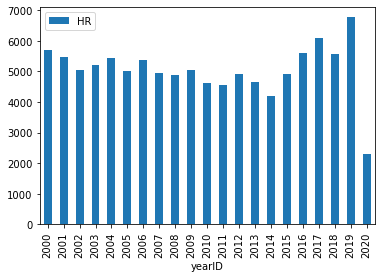

In [16]:
newBaseball.plot.bar(x='yearID', y='HR', rot=90)

It appears that there is a general upwards trend in homeruns hit each year with a steep decrease in 2020 because COVID-19 shortened the season dramatically. We expect to see all of the predictors values to reflect this decrease proportionately. In 2021, it is expected that the number of homeruns will return to the rising trend over the last decade. In the baseball community, this has become known as the "live ball era" because of the upwards trend in homeruns. 

Now that we have our data laid out in terms of total stats per year, we can continue.

In [10]:
mod = smf.ols(formula='HR ~ G + AB + R + H + Double + Triple + RBI + SB + CS', data = newBaseball)

In [11]:
res = mod.fit()
res.summary()

C:\Users\jpric\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     HR   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     146.3
Date:                Wed, 01 Dec 2021   Prob (F-statistic):             0.0641
Time:                        00:25:43   Log-Likelihood:                -53.189
No. Observations:                  11   AIC:                             126.4
Df Residuals:                       1   BIC:                             130.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1258.4434    432.494     -2.910      0.211   -6753.802    4236.915
G              0.4542      0.309      1.472      0.380      -3.466       4.375
AB            -0.1769      0.184     -0.964      0.512      -2.509       2.155
R             -8.7193      3.932     -2.217      0.270     -58.686      41.247
H              0.2337      0.255      0.917      0.528      -3.005       3.472
Double        -0.9208      1.031     -0.893      0.536     -14.024      12.183
Triple        -2.4744      2.053     -1.206      0.441     -28.555      23.606
RBI            9.2650      3.775      2.454      0.246     -38.701      57.231
SB             0.6874      0.615      1.118      0.465      -7.126       8.501
CS            -0.2818      1.361     -0.207      0.870     -17.579      17.016
==============================================================================
Omnibus:                        3.958   Durbin-Watson:                   3.016
Prob(Omnibus):                  0.138   Jarque-Bera (JB):                1.126
Skew:                          -0.046   Prob(JB):                        0.570
Kurtosis:                       1.435   Cond. No.                     2.55e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We decided to do a VIF analysis to determine collinearity in the predictors and found that many of the variables had a VIF score of above ten. This indicates a large amount of collinearity. We will not drop the predictors because of this but it is important to keep in mind as we head into our next step of subset selection. 

In [12]:
vif = pd.DataFrame()
vif['X'] = baseball.columns
vif['vif'] = [variance_inflation_factor(baseball.values, i) for i in range(len(baseball.columns))]
vif

,X,vif
0,yearID,2.928270
1,G,13.557441
2,AB,189.622803
3,R,73.863338
4,H,188.859951
5,Double,23.061349
6,Triple,3.031186
7,HR,22.684014
8,RBI,60.123235
9,SB,4.260707


We are going to use forward subset selection and backwards subset selection to determine which predictors we are going to actually use in our final model. Because we are doing both, we are more likely to get a more accurate final model.